This is an implementation from scrath on Keras of the image classification competition. A lot of the code has been referenced from many of the documentations available for Keras and also by other deep learning enthusiasts who have implemented their own versions. I am thankful to them for keeping their work public so that it can be reused and referenced by others.

Below we import all the different packages

In [35]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
from glob import glob 
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import math
import pandas as pd
import os
print(os.listdir("../input"))
#print(os.listdir("../input/test"))
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory


# Any results you write to the current directory are saved as output.

['test', 'train', 'sample_submission.csv']


Using glob package we load the files into a a separate train and test path

In [36]:
train_path = '../input/train/*/*.png' 
test_path = '../input/test/*.png' 
train_files = glob(train_path)
test_files = glob(test_path)

In [37]:
train_images = []
train_label = []
for img in train_files:
    train_images.append(cv2.resize(cv2.imread(img), (80,80)))
    train_label.append(img.split('/')[-2])

train_images = np.asarray(train_images)
train_label = pd.DataFrame(train_label)

print("The type of train images is:",type(train_images.shape))
print("The shape of train images is:",train_images.shape)
print("The type of train labels is:",type(train_label))
print(("The shape of train labels is:",train_label.shape))

test_images = []
test_label = []
for img1 in test_files:
    test_images.append(cv2.resize(cv2.imread(img1), (80,80)))
    test_label.append(img.split('/')[-2])
test_images = np.asarray(test_images)
test_label = pd.DataFrame(test_label)

print("The type of test images is:",type(test_images.shape))
print("The shape of test images is:",test_images.shape)
print("The type of test labels is:",type(test_label))
print(("The shape of test labels is:",test_label.shape))


The type of train images is: <class 'tuple'>
The shape of train images is: (4750, 80, 80, 3)
The type of train labels is: <class 'pandas.core.frame.DataFrame'>
('The shape of train labels is:', (4750, 1))
The type of test images is: <class 'tuple'>
The shape of test images is: (794, 80, 80, 3)
The type of test labels is: <class 'pandas.core.frame.DataFrame'>
('The shape of test labels is:', (794, 1))


Some sample  images from the data set

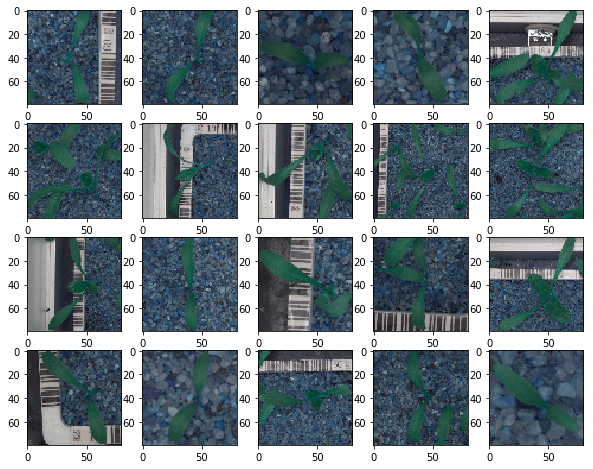

In [38]:
plt.rcParams['figure.figsize'] = (10.0,8.0)
for i in range(20):
    plt.subplot(4,5,i+1)
    plt.imshow(train_images[i])

Here we normalise the image and divide it by 255 i.e. max pixel value. It also speeds up the training

In [39]:
train_images = train_images/255
test_images = test_images/255

We encode the training labels to 0s and 1s

In [40]:
from keras.utils import np_utils
from sklearn import preprocessing

label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(train_label[0])
print("The different species of plants are: " + str(label_encoder.classes_))
encoded_train_labels = label_encoder.transform(train_label[0])

#Convert it to categorical encoders of 0s and 1s
encoded_train_labels = np_utils.to_categorical(encoded_train_labels)
num_clases = encoded_train_labels.shape[1]
print("The total plant categories are: " + str(num_clases))

The different species of plants are: ['Black-grass' 'Charlock' 'Cleavers' 'Common Chickweed' 'Common wheat'
 'Fat Hen' 'Loose Silky-bent' 'Maize' 'Scentless Mayweed'
 'Shepherds Purse' 'Small-flowered Cranesbill' 'Sugar beet']
The total plant categories are: 12


Create the training and validation splits

In [41]:
#Creating the training and validation splits:
from sklearn.model_selection import train_test_split
seed = 100
trainX, validationX, trainY, validationY = train_test_split(train_images, encoded_train_labels, 
                                                test_size=0.08, random_state=seed, 
                                                stratify = encoded_train_labels)

In [42]:
print(trainX.shape)
print(trainY.shape)
print(validationX.shape)
print(validationY.shape)

(4370, 80, 80, 3)
(4370, 12)
(380, 80, 80, 3)
(380, 12)


This is the architecture that we are building. I was getting errors if I tried taking strides in the convolutions but I hope to rectify that in future.

In [43]:
import numpy
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import BatchNormalization
from keras import backend as K
K.set_image_dim_ordering('tf')

model = Sequential()

model.add(Conv2D(filters=64, kernel_size=(3,3), input_shape=(80, 80, 3), activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.12))

model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.12))

model.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.12))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(num_clases, activation='softmax'))

model.summary()

# compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 78, 78, 64)        1792      
_________________________________________________________________
batch_normalization_19 (Batc (None, 78, 78, 64)        256       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 76, 76, 64)        36928     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 38, 38, 64)        0         
_________________________________________________________________
batch_normalization_20 (Batc (None, 38, 38, 64)        256       
_________________________________________________________________
dropout_13 (Dropout)         (None, 38, 38, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 36, 36, 128)       73856     
__________

You fit the model in the below step. Feel free to tinker with batch_size and epoch number. There are many other parameters that you can tweak.

In [44]:
#Fit the model on the above architecture. 
plant_model = model.fit(trainX, trainY, epochs=15, batch_size=128, validation_data = (validationX, validationY))

Train on 4370 samples, validate on 380 samples
Epoch 1/15
4370/4370 [==============================] - 532s 122ms/step - loss: 2.3336 - acc: 0.3018 - val_loss: 4.0556 - val_acc: 0.2684
Epoch 2/15
4370/4370 [==============================] - 529s 121ms/step - loss: 1.3279 - acc: 0.5673 - val_loss: 3.8746 - val_acc: 0.3553
Epoch 3/15
4370/4370 [==============================] - 520s 119ms/step - loss: 0.9958 - acc: 0.6725 - val_loss: 1.9754 - val_acc: 0.5605
Epoch 4/15
4370/4370 [==============================] - 513s 117ms/step - loss: 0.7645 - acc: 0.7432 - val_loss: 1.5501 - val_acc: 0.6132
Epoch 5/15
4370/4370 [==============================] - 515s 118ms/step - loss: 0.6017 - acc: 0.7968 - val_loss: 1.7866 - val_acc: 0.5868
Epoch 6/15
4370/4370 [==============================] - 517s 118ms/step - loss: 0.5388 - acc: 0.8098 - val_loss: 2.5519 - val_acc: 0.5026
Epoch 7/15
4370/4370 [==============================] - 514s 118ms/step - loss: 0.4519 - acc: 0.8442 - val_loss: 1.0073 - val

Helps save weights for future. Avoids re training if you lose kernel connection.

In [45]:
from keras.models import load_model
model.save('my_model.h5') 

In [46]:
model.load_weights("my_model.h5")

This is to get the file format in which Kaggle requires its submissions to be in

In [47]:
test_file_names = []
for file in glob(test_path):
    test_file_names.append(file.split('/')[-1])

print(test_file_names)

['26e7ae885.png', 'e80a259c5.png', '3f64c2c1b.png', '1312065a5.png', '47b7d8e17.png', 'c0f5d9ac8.png', 'ab0f67743.png', 'da9ef7858.png', '5f04aed97.png', 'fba8fc78a.png', '632156793.png', '4bbfd1e05.png', '74fd477eb.png', '060450d79.png', 'cae684f8f.png', '86f08e6d1.png', 'a8c8a1db0.png', '456d507c0.png', 'f48916a8c.png', 'dc55449b2.png', '52dc7a4d6.png', '862b8e7a0.png', '5eb9c26a6.png', '20817c846.png', 'bf3924a57.png', 'f6d250856.png', '3dd52bd2a.png', '2d5058a59.png', '61dd2cdc5.png', '36839d5e9.png', '8a4d3a1b1.png', 'a8b431a3e.png', '8c9953903.png', '8b9144917.png', 'bffc08672.png', 'bb1c84bbc.png', '5bbc0a255.png', '7a38416be.png', '969a851be.png', '8916793ce.png', '1b490196c.png', '241e6935a.png', '8a30b2de3.png', '37714071b.png', '3526b05cc.png', 'beebe5f4e.png', '8bc0261c9.png', 'e52493d0b.png', '0437393b1.png', '0f6cbe5e8.png', 'e98e5d1d5.png', '8cf2e3e6c.png', '98d819587.png', '53e6e9000.png', '8ece6efec.png', '6b9d6f8c9.png', '3827436f3.png', '0dba99002.png', 'e88bf0db9.pn

In [48]:
preditions = model.predict(test_images)
prediction_class_Index = np.argmax(preditions, axis=1)
prediction_class = label_encoder.classes_[prediction_class_Index]
sumbit = {'file': test_file_names, 'species': prediction_class}

sumbit = pd.DataFrame(sumbit)
sumbit.to_csv("sumbit.csv", index=False)

Print the submission. In the end, you need to submit the data in this format

In [49]:
print(type(sumbit))
print(sumbit)

<class 'pandas.core.frame.DataFrame'>
              file                    species
0    26e7ae885.png                    Fat Hen
1    e80a259c5.png  Small-flowered Cranesbill
2    3f64c2c1b.png               Common wheat
3    1312065a5.png  Small-flowered Cranesbill
4    47b7d8e17.png  Small-flowered Cranesbill
5    c0f5d9ac8.png  Small-flowered Cranesbill
6    ab0f67743.png                Black-grass
7    da9ef7858.png                   Charlock
8    5f04aed97.png  Small-flowered Cranesbill
9    fba8fc78a.png           Loose Silky-bent
10   632156793.png                   Charlock
11   4bbfd1e05.png                   Charlock
12   74fd477eb.png           Common Chickweed
13   060450d79.png           Common Chickweed
14   cae684f8f.png                   Charlock
15   86f08e6d1.png  Small-flowered Cranesbill
16   a8c8a1db0.png            Shepherds Purse
17   456d507c0.png                   Cleavers
18   f48916a8c.png           Common Chickweed
19   dc55449b2.png                 Sugar b